In [31]:
import sys
import glob
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.saving import load_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import nibabel as nib
from Load_data import *
seed = 42

In [32]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [33]:
img_path = '/Volumes/DESKTOP_Extended/PROSTATEx_masks/Files/prostate/Images/'
mask_path = '/Volumes/DESKTOP_Extended/PROSTATEx_masks/Files/prostate/mask_prostate/'


In [34]:
images, masks = loading_data_to_array(img_path, mask_path)

In [36]:
len(images) == len(masks)

True

In [37]:
train_img = np.zeros((len(images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
train_msk = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
for i in range(len(images)):
    images[i] = images[i].reshape((images[i].shape[0], images[i].shape[1], 1))
    img = images[i][:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range= True)
    #img = img.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    train_img[i] = img

for i in range(len(masks)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    mask_ = masks[i]
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    train_msk[i] = mask

In [38]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [39]:
import segmentation_models as sm
sm.set_framework('tf.keras')
BACKBONE = 'resnet50'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `tf.keras` framework.


In [40]:
train_img = preprocess_input1(train_img)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_img, train_msk, test_size = 0.1, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(1312, 128, 128, 3)
(146, 128, 128, 3)


In [42]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [43]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [44]:
early_stopping = EarlyStopping(monitor='val_iou_score', patience=5)

In [45]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=20, callbacks=[early_stopping], verbose=1)

2023-10-03 18:26:49.978688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 1.3749 - iou_score: 0.0451 

2023-10-03 18:39:13.011786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 874s 17s/step - loss: 1.3749 - iou_score: 0.0451 - val_loss: 1.9449 - val_iou_score: 0.0056
Epoch 2/20
50/50 [==============================] - 826s 17s/step - loss: 1.0142 - iou_score: 0.1391 - val_loss: 1.5235 - val_iou_score: 0.0534
Epoch 3/20
50/50 [==============================] - 820s 16s/step - loss: 0.8530 - iou_score: 0.2617 - val_loss: 1.1056 - val_iou_score: 0.1427
Epoch 4/20
50/50 [==============================] - 759s 15s/step - loss: 0.7846 - iou_score: 0.3266 - val_loss: 1.2107 - val_iou_score: 0.0084
Epoch 5/20
50/50 [==============================] - 725s 14s/step - loss: 0.7507 - iou_score: 0.3566 - val_loss: 1.2274 - val_iou_score: 0.0107
Epoch 6/20
50/50 [==============================] - 780s 16s/step - loss: 0.7216 - iou_score: 0.3816 - val_loss: 1.2592 - val_iou_score: 0.0051
Epoch 7/20
50/50 [==============================] - 718s 14s/step - loss: 0.7130 - iou_score: 0.3889 - val_loss: 1.1306 - val_iou_score: 0.0923
Epo

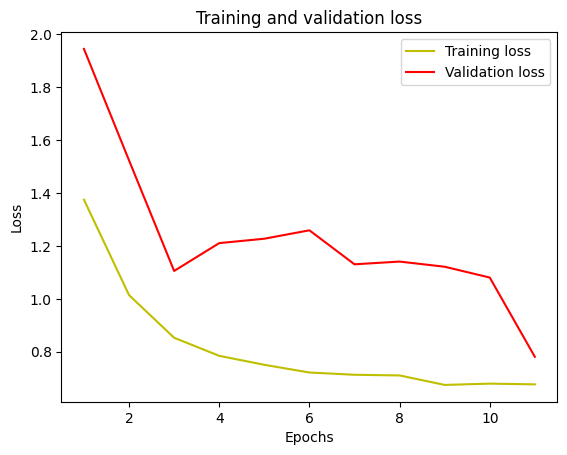

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

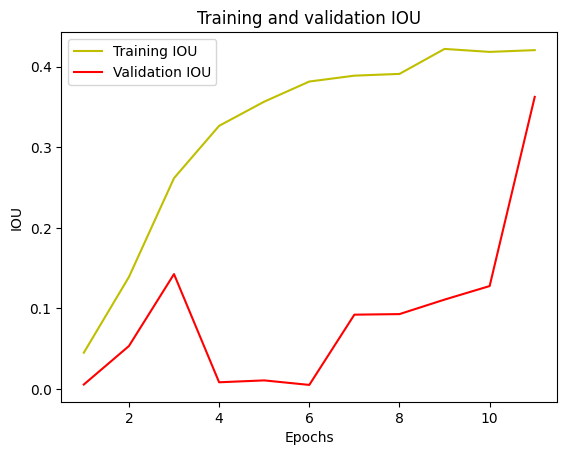

In [51]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [52]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

5/5 [==============================] - 12s 2s/step
IoU socre is:  0.40559321426009615


1/1 [==============================] - 0s 160ms/step


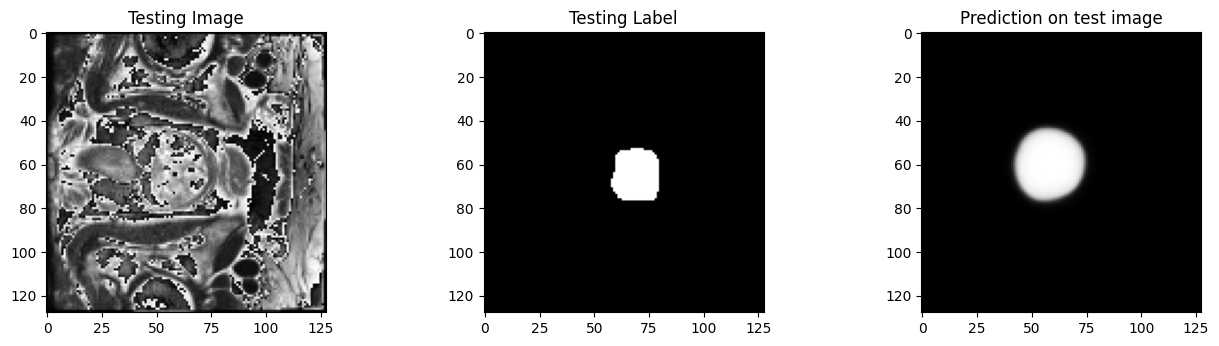

In [57]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()

In [58]:
model.save('UR.h5')